In [131]:
%load_ext autoreload
%autoreload 2
from birdclef.utils import get_spark
from pyspark.sql import functions as F, Window
import pandas as pd
import matplotlib.pyplot as plt

spark = get_spark()
spark

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


24/06/21 05:46:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
path = "gs://dsgt-clef-birdclef-2024/data/processed/google_embeddings/v1"
train = spark.read.parquet(path).cache()
train.printSchema()
train.count()

root
 |-- name: string (nullable = true)
 |-- chunk_5s: long (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- logits: array (nullable = true)
 |    |-- element: float (containsNull = true)



217814

In [3]:
path = "gs://dsgt-clef-birdclef-2024/data/processed/google_soundscape_embeddings/v1"
soundscape = spark.read.parquet(path)
soundscape.printSchema()
soundscape.count()

root
 |-- name: string (nullable = true)
 |-- chunk_5s: long (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- logits: array (nullable = true)
 |    |-- element: double (containsNull = true)



407641

## how many hours of audio?

In [6]:
train.count() * 5 / 3600, soundscape.count() * 5 / 3600

(302.51944444444445, 566.1680555555556)

## what percentage of birdcalls?

In [8]:
from birdclef.config import SPECIES
import numpy as np


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


@F.udf("array<string>")
def remap_logits_udf(logits):
    probs = sigmoid(np.array(logits))
    return [SPECIES[i] for i, p in enumerate(probs) if p > 0.5]

In [10]:
train.select(remap_logits_udf("logits").alias("predictions")).show(n=5)

+-----------+
|predictions|
+-----------+
|         []|
|  [bncwoo3]|
|         []|
|  [bncwoo3]|
|  [bncwoo3]|
+-----------+
only showing top 5 rows



In [18]:
# count predictions and co-occurences
train_co = (
    train.select(remap_logits_udf("logits").alias("predictions"))
    .groupBy(F.size("predictions").alias("co_occur_size"))
    .agg(F.count("*").alias("n"))
    .orderBy("co_occur_size")
).toPandas()
train_co

,co_occur_size,n
0,0,82575
1,1,128177
2,2,2948
3,3,423
4,4,137
5,5,121
6,6,543
7,7,2487
8,8,106
9,9,73


In [20]:
train_co[train_co.co_occur_size > 0].n.sum() / train_co.n.sum()

0.620892137328179

In [21]:
soundscape_co = (
    soundscape.select(remap_logits_udf("logits").alias("predictions"))
    .groupBy(F.size("predictions").alias("co_occur_size"))
    .agg(F.count("*").alias("n"))
    .orderBy("co_occur_size")
).toPandas()
soundscape_co.head()

,co_occur_size,n
0,0,371661
1,1,28942
2,2,1472
3,3,236
4,4,133


In [22]:
soundscape_co[soundscape_co.co_occur_size > 0].n.sum() / soundscape_co.n.sum()

0.08826393812202403

## comparative analysis of species in each set

* as a fraction of instances
* as a fraction of calls

In [140]:
# let's compare the two distributions, using plus one smoothing
def total_audio(df):
    exploded = df.select(
        "name",
        "chunk_5s",
        F.explode(remap_logits_udf("logits")).alias("species"),
    )
    counts = (
        (exploded.groupBy("species").agg(F.count("*").alias("n")).orderBy(F.desc("n")))
        # add-one smoothing
        .union(spark.createDataFrame([{"species": s, "n": 1} for s in SPECIES]))
        .groupBy("species")
        .agg(F.sum("n").alias("n"))
        .orderBy(F.desc("n"))
    ).cache()
    count_calls = df.select("name", "chunk_5s").distinct().count()
    return counts.withColumn("frac_calls", F.col("n") / count_calls).select(
        "species",
        "n",
        "frac_calls",
        # normalized n
        (F.col("n") / F.sum("n").over(Window.partitionBy())).alias("n_norm"),
        # normalized frac_calls
        (F.col("frac_calls") / F.sum("frac_calls").over(Window.partitionBy())).alias(
            "frac_calls_norm"
        ),
    )


train_dist = total_audio(train).cache()
train_dist.show(n=10)

24/06/21 05:52:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:52:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:52:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:52:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:52:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:52:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 0

+-------+-------+--------------------+--------------------+--------------------+
|species|      n|          frac_calls|              n_norm|     frac_calls_norm|
+-------+-------+--------------------+--------------------+--------------------+
|bncwoo3|14170.0| 0.06505550607398973| 0.08736936214816414| 0.08736936214816414|
| grnsan| 8069.0|0.037045368984546447|0.049751826617751335| 0.04975182661775134|
|inbrob1| 7189.0|0.033005224641207635| 0.04432592409902272| 0.04432592409902273|
|comior1| 6575.0| 0.03018630574710533| 0.04054012393254617|0.040540123932546177|
| lirplo| 6423.0|0.029488462633255896| 0.03960292258840213| 0.03960292258840214|
|bkrfla1| 6260.0| 0.02874011771511473| 0.03859789746277399|   0.038597897462774|
|comtai1| 5664.0|0.026003838137126173|  0.0349230816659987|0.034923081665998716|
|houcro1| 4774.0|0.021917783062613057|0.029435521164102724| 0.02943552116410273|
| comsan| 4214.0|0.019346782116851993| 0.02598267410672997|0.025982674106729973|
|btbeat1| 3749.0|0.017211933

In [141]:
soundscape_dist = total_audio(soundscape).cache()
soundscape_dist.show(n=10)

24/06/21 05:53:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:53:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:53:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:53:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:53:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------+------+--------------------+--------------------+--------------------+
|species|     n|          frac_calls|              n_norm|     frac_calls_norm|
+-------+------+--------------------+--------------------+--------------------+
| grnsan|6272.0|0.015386087267963724| 0.09052464458396478| 0.09052464458396484|
|comior1|5648.0|0.013855328585691822| 0.08151836616872339| 0.08151836616872343|
| lirplo|5638.0| 0.01383079719655285| 0.08137403478386375| 0.08137403478386379|
|bkrfla1|5532.0|0.013570764471679738| 0.07984412210435159| 0.07984412210435164|
|comtai1|5323.0|0.013058058438675206| 0.07682759616078516|  0.0768275961607852|
|btbeat1|5189.0|0.012729337824212972| 0.07489355560366602| 0.07489355560366606|
|putbab1|5009.0|0.012287772819711463| 0.07229559067619254| 0.07229559067619258|
|purher1|4735.0|0.011615612757303608| 0.06834091073103847|  0.0683409107310385|
|whcbar1|4057.0|0.009952384573681253|0.058555242837555026|0.058555242837555053|
|mawthr1|3114.0|0.007639074577876121| 0.

24/06/21 05:53:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:53:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [145]:
def relabel(df, prefix):
    return df.selectExpr(
        "species",
        *[f"{c} as {prefix}_{c}" for c in df.columns if c != "species"],
    )


joined_dist = (
    relabel(train_dist, "train")
    .join(
        relabel(soundscape_dist, "soundscape"),
        "species",
        "outer",
    )
    .fillna(0)
    .orderBy(F.desc("soundscape_n"))
)
joined_dist.show(n=10)
joined_dist.select(*[F.sum(c) for c in joined_dist.columns[1:]]).show()
joined_dist_pdf = joined_dist.toPandas()

24/06/21 05:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------+-------+--------------------+--------------------+---------------------+------------+---------------------+--------------------+--------------------------+
|species|train_n|    train_frac_calls|        train_n_norm|train_frac_calls_norm|soundscape_n|soundscape_frac_calls|   soundscape_n_norm|soundscape_frac_calls_norm|
+-------+-------+--------------------+--------------------+---------------------+------------+---------------------+--------------------+--------------------------+
| grnsan| 8069.0|0.037045368984546447|0.049751826617751335|  0.04975182661775134|      6272.0| 0.015386087267963724| 0.09052464458396478|       0.09052464458396484|
|comior1| 6575.0| 0.03018630574710533| 0.04054012393254617| 0.040540123932546177|      5648.0| 0.013855328585691822| 0.08151836616872339|       0.08151836616872343|
| lirplo| 6423.0|0.029488462633255896| 0.03960292258840213|  0.03960292258840214|      5638.0|  0.01383079719655285| 0.08137403478386375|       0.08137403478386379|
|bkrfla1| 

24/06/21 05:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:54:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------------+---------------------+------------------+--------------------------+-----------------+--------------------------+----------------------+-------------------------------+
|sum(train_n)|sum(train_frac_calls)| sum(train_n_norm)|sum(train_frac_calls_norm)|sum(soundscape_n)|sum(soundscape_frac_calls)|sum(soundscape_n_norm)|sum(soundscape_frac_calls_norm)|
+------------+---------------------+------------------+--------------------------+-----------------+--------------------------+----------------------+-------------------------------+
|    162185.0|   0.7446031935504601|0.9999999999999998|                       1.0|          69285.0|       0.16996572964937276|    0.9999999999999987|             0.9999999999999994|
+------------+---------------------+------------------+--------------------------+-----------------+--------------------------+----------------------+-------------------------------+



24/06/21 05:54:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:54:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:54:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/21 05:54:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


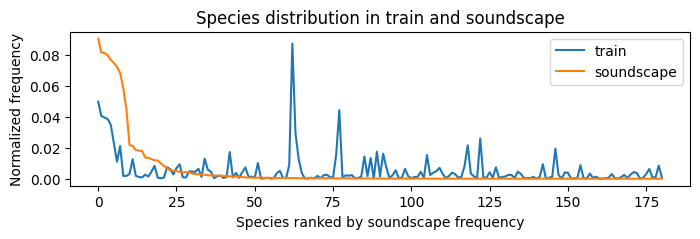

In [147]:
plt.figure(figsize=(8, 2))
joined_dist_pdf.train_frac_calls_norm.plot(label="train")
joined_dist_pdf.soundscape_frac_calls_norm.plot(label="soundscape")
plt.legend()
plt.xlabel("Species ranked by soundscape frequency")
plt.ylabel("Normalized frequency")
plt.title("Species distribution in train and soundscape")
plt.show()

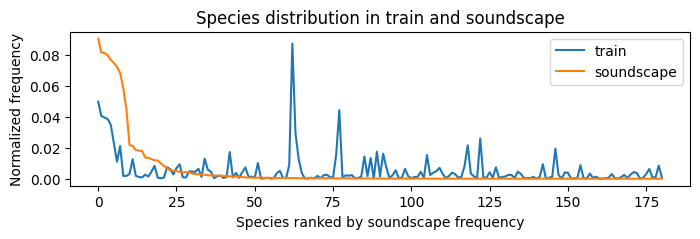

In [148]:
plt.figure(figsize=(8, 2))
joined_dist_pdf.train_n_norm.plot(label="train")
joined_dist_pdf.soundscape_n_norm.plot(label="soundscape")
plt.legend()
plt.xlabel("Species ranked by soundscape frequency")
plt.ylabel("Normalized frequency")
plt.title("Species distribution in train and soundscape")
plt.show()

In [68]:
# compute the KL-divergence between the two distributions
from scipy.stats import entropy

kl_div = entropy(joined_dist_pdf.soundscape_frac, joined_dist_pdf.train_frac)
kl_div

1.275853547081951

## comparative analysis of co-occurring species

In [76]:
from pyspark.ml.fpm import FPGrowth


def freq_itemsets(df):
    fp = FPGrowth(itemsCol="predicted", minSupport=0.01)
    exploded = df.select(
        "name",
        "chunk_5s",
        F.explode(remap_logits_udf("logits")).alias("species"),
    )
    # now aggregate by name
    aggregated = exploded.groupBy("name").agg(
        F.collect_set("species").alias("predicted")
    )
    model = fp.fit(aggregated)
    return model.freqItemsets.orderBy(F.desc("freq")).cache(), model


train_itemsets, train_model = freq_itemsets(train)
train_itemsets.show(n=10)
train_itemsets.count()

+--------------------+----+
|               items|freq|
+--------------------+----+
|           [comior1]|3019|
|            [lirplo]|2943|
|           [bkrfla1]|2929|
|            [grnsan]|2739|
|           [comtai1]|2612|
|   [lirplo, comior1]|2530|
|   [bkrfla1, lirplo]|2475|
|  [bkrfla1, comior1]|2474|
|[bkrfla1, lirplo,...|2472|
|   [grnsan, bkrfla1]|2249|
+--------------------+----+
only showing top 10 rows



605

In [78]:
train_itemsets.groupBy(F.size("items").alias("size")).count().orderBy("size").show()

+----+-----+
|size|count|
+----+-----+
|   1|   40|
|   2|   42|
|   3|   99|
|   4|  146|
|   5|  141|
|   6|   90|
|   7|   37|
|   8|    9|
|   9|    1|
+----+-----+



In [92]:
# can we compute the consequent for each of the species?
single_df = spark.createDataFrame([(s,) for s in SPECIES], ["species"]).withColumn(
    "predicted", F.array("species")
)
# single_df.show(n=5)
train_model.transform(single_df).where(F.size("prediction") > 0).show()

+-------+---------+--------------------+
|species|predicted|          prediction|
+-------+---------+--------------------+
|bkrfla1|[bkrfla1]|   [lirplo, comior1]|
|btbeat1|[btbeat1]|[purher1, bkrfla1...|
|comior1|[comior1]|   [lirplo, bkrfla1]|
|comtai1|[comtai1]|[bkrfla1, lirplo,...|
| grnsan| [grnsan]|[bkrfla1, lirplo,...|
| lirplo| [lirplo]|  [comior1, bkrfla1]|
|purher1|[purher1]|[bkrfla1, btbeat1...|
+-------+---------+--------------------+



In [107]:
soundscape_itemsets, soundscape_model = freq_itemsets(soundscape)
soundscape_itemsets.show(truncate=False)
soundscape_itemsets.count()

+-----------------------------------+----+
|items                              |freq|
+-----------------------------------+----+
|[comior1]                          |5320|
|[lirplo]                           |5308|
|[lirplo, comior1]                  |5307|
|[bkrfla1]                          |5283|
|[bkrfla1, lirplo]                  |5280|
|[bkrfla1, lirplo, comior1]         |5280|
|[bkrfla1, comior1]                 |5280|
|[grnsan]                           |5197|
|[grnsan, comior1]                  |5169|
|[grnsan, lirplo]                   |5168|
|[grnsan, lirplo, comior1]          |5168|
|[grnsan, bkrfla1]                  |5167|
|[grnsan, bkrfla1, lirplo]          |5167|
|[grnsan, bkrfla1, lirplo, comior1] |5167|
|[grnsan, bkrfla1, comior1]         |5167|
|[comtai1]                          |5084|
|[comtai1, bkrfla1]                 |5079|
|[comtai1, bkrfla1, lirplo]         |5079|
|[comtai1, bkrfla1, lirplo, comior1]|5079|
|[comtai1, bkrfla1, comior1]        |5079|
+----------

4144

In [94]:
soundscape_itemsets.groupBy(F.size("items").alias("size")).count().orderBy(
    "size"
).show()

+----+-----+
|size|count|
+----+-----+
|   1|   35|
|   2|  196|
|   3|  582|
|   4| 1021|
|   5| 1117|
|   6|  775|
|   7|  331|
|   8|   79|
|   9|    8|
+----+-----+



<Axes: xlabel='size'>

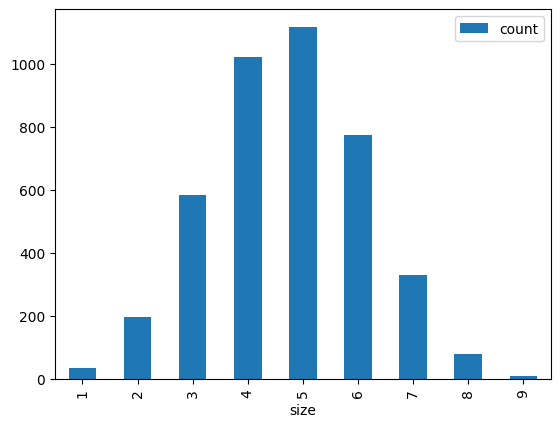

In [237]:
res = (
    soundscape_itemsets.groupBy(F.size("items").alias("size"))
    .count()
    .orderBy("size")
    .toPandas()
)

# reduce spacing between bars
res.plot.bar(x="itemset size", y="frequency")

In [98]:
soundscape_rules = soundscape_model.transform(single_df).where(F.size("prediction") > 0)
soundscape_rules.show()

+-------+---------+--------------------+
|species|predicted|          prediction|
+-------+---------+--------------------+
|bkrfla1|[bkrfla1]|[lirplo, comior1,...|
|btbeat1|[btbeat1]|[bkrfla1, comtai1...|
|comior1|[comior1]|[bkrfla1, btbeat1...|
|comtai1|[comtai1]|[btbeat1, bkrfla1...|
|cregos1|[cregos1]|[bkrfla1, comtai1...|
|dafbab1|[dafbab1]|[bkrfla1, comtai1...|
| grnsan| [grnsan]|[btbeat1, comtai1...|
|grtdro1|[grtdro1]|[bkrfla1, btbeat1...|
|lblwar1|[lblwar1]|[bkrfla1, btbeat1...|
| lirplo| [lirplo]|[bkrfla1, btbeat1...|
|pabflo1|[pabflo1]|[bkrfla1, btbeat1...|
|plaflo1|[plaflo1]|[bkrfla1, btbeat1...|
|purher1|[purher1]|[bkrfla1, btbeat1...|
| spodov| [spodov]|[bkrfla1, btbeat1...|
|sqtbul1|[sqtbul1]|[bkrfla1, btbeat1...|
|vehpar1|[vehpar1]|[bkrfla1, btbeat1...|
+-------+---------+--------------------+



In [100]:
# turn into edges
soundscape_edges = soundscape_rules.select(
    F.col("species").alias("src"), F.explode("prediction").alias("dst")
)
soundscape_edges.count()

100

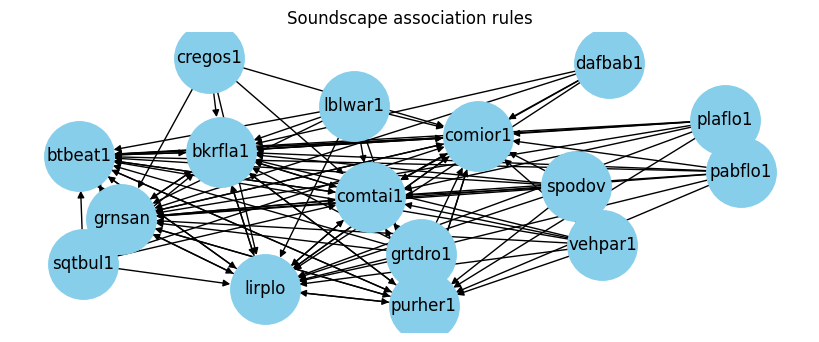

In [235]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(soundscape_edges.collect())
plt.figure(figsize=(8, 3))
nx.draw(G, with_labels=True, node_size=2500, node_color="skyblue")
plt.title("Soundscape association rules")
plt.show()

## using predictions to cluster

In [151]:
@F.udf("array<float>")
def extract_logits(logits):
    sorted_logits = sorted(logits, key=lambda r: r.species)
    return [r.logit for r in sorted_logits]


summarized = (
    soundscape.select("name", F.posexplode("logits").alias("species", "logit"))
    .groupBy("name", "species")
    .agg(F.max("logit").alias("logit"))
    .groupBy("name")
    .agg(F.collect_list(F.struct("species", "logit")).alias("logits"))
    .select("name", extract_logits("logits").alias("logits"))
).cache()
summarized.show()

+--------------+--------------------+
|          name|              logits|
+--------------+--------------------+
|1000170626.ogg|[-Infinity, -Infi...|
|1001358022.ogg|[-Infinity, -Infi...|
|1004032111.ogg|[-Infinity, -Infi...|
|1005741050.ogg|[-Infinity, -Infi...|
|1006166529.ogg|[-Infinity, -Infi...|
|1008685149.ogg|[-Infinity, -Infi...|
|1010575610.ogg|[-Infinity, -Infi...|
| 101125218.ogg|[-Infinity, -Infi...|
|1012206837.ogg|[-Infinity, -Infi...|
|1012842173.ogg|[-Infinity, -Infi...|
|  10146969.ogg|[-Infinity, -Infi...|
|1015325399.ogg|[-Infinity, -Infi...|
|1017371115.ogg|[-Infinity, -Infi...|
|1017565224.ogg|[-Infinity, -Infi...|
|1017730633.ogg|[-Infinity, -Infi...|
|1018192609.ogg|[-Infinity, -Infi...|
|1018822946.ogg|[-Infinity, -Infi...|
|1019241968.ogg|[-Infinity, -Infi...|
|1019489898.ogg|[-Infinity, -Infi...|
|1020071719.ogg|[-Infinity, -Infi...|
+--------------+--------------------+
only showing top 20 rows



In [152]:
summarized_pdf = summarized.toPandas()

In [156]:
import umap

X = sigmoid(np.stack(summarized_pdf.logits.values))
X.shape

(8444, 182)

In [157]:
# let's plot it and see how it goes

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


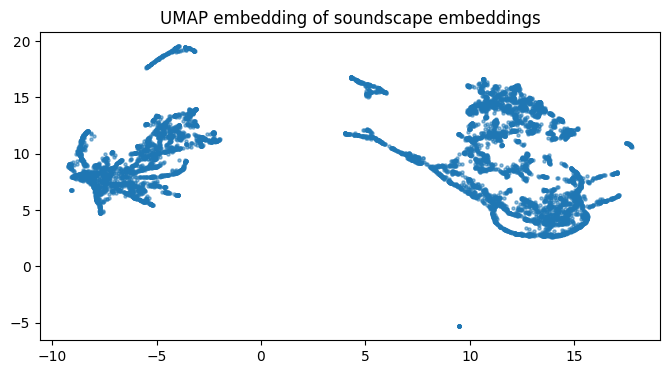

In [161]:
plt.figure(figsize=(8, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.5)
plt.title("UMAP embedding of soundscape embeddings")
plt.show()

In [162]:
import pacmap

reducer = pacmap.PaCMAP()
embedding = reducer.fit_transform(X)

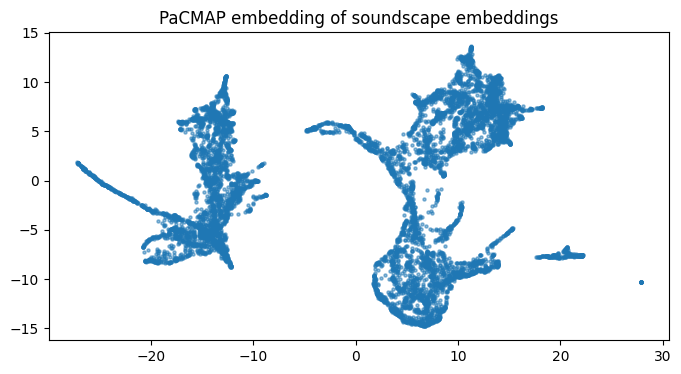

In [163]:
plt.figure(figsize=(8, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.5)
plt.title("PaCMAP embedding of soundscape embeddings")
plt.show()

In [215]:
# can we use the mean of the embeddings instead?
@F.pandas_udf("array<float>", F.PandasUDFType.GROUPED_AGG)
def aggregate_logits(logits):
    X = np.stack(logits.values)
    return np.max(sigmoid(X), axis=0)


@F.pandas_udf("array<float>", F.PandasUDFType.GROUPED_AGG)
def aggregate_emb(logits):
    X = np.stack(logits.values)
    # concat mean, min, max
    return np.mean(X, axis=0)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [218]:
results = {}

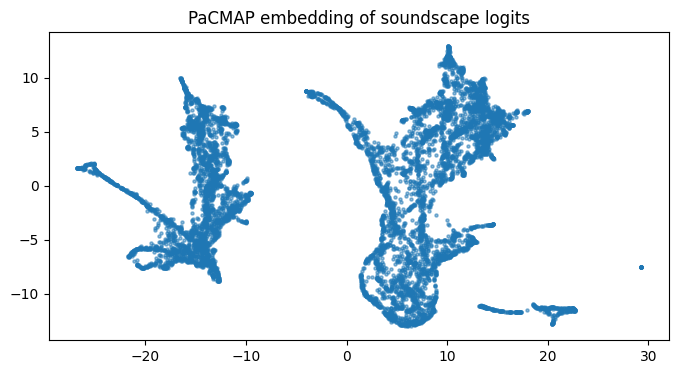

In [219]:
summarized = soundscape.groupBy("name").agg(aggregate_logits("logits").alias("probs"))
X = np.stack(summarized.toPandas().probs.values)
embedding = pacmap.PaCMAP().fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.5)
plt.title("PaCMAP embedding of soundscape logits")
plt.show()
results["soundscape logits"] = embedding

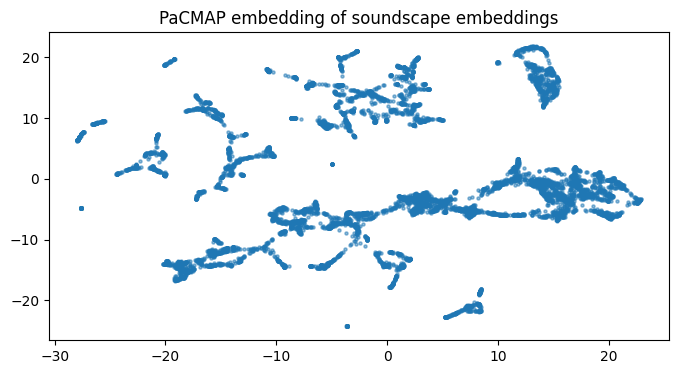

In [220]:
summarized = soundscape.groupBy("name").agg(aggregate_emb("embedding").alias("probs"))
X = np.stack(summarized.toPandas().probs.values)
embedding = pacmap.PaCMAP().fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.5)
plt.title("PaCMAP embedding of soundscape embeddings")
plt.show()
results["soundscape embeddings"] = embedding

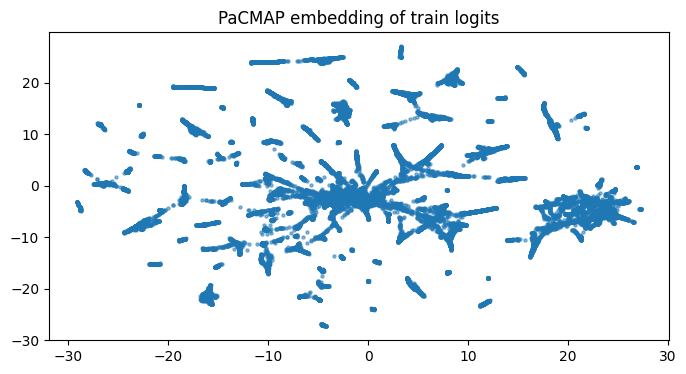

In [221]:
summarized = train.groupBy("name").agg(aggregate_logits("logits").alias("probs"))
X = np.stack(summarized.toPandas().probs.values)
embedding = pacmap.PaCMAP().fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.5)
plt.title("PaCMAP embedding of train logits")
plt.show()
results["train logits"] = embedding

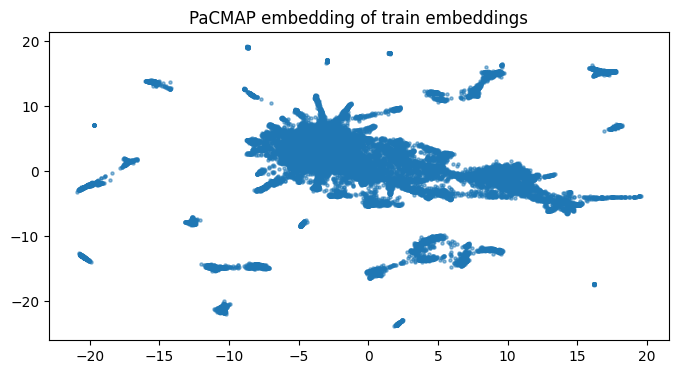

In [222]:
summarized = train.groupBy("name").agg(aggregate_emb("embedding").alias("probs"))
X = np.stack(summarized.toPandas().probs.values)
embedding = pacmap.PaCMAP().fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.5)
plt.title("PaCMAP embedding of train embeddings")
plt.show()
results["train embeddings"] = embedding

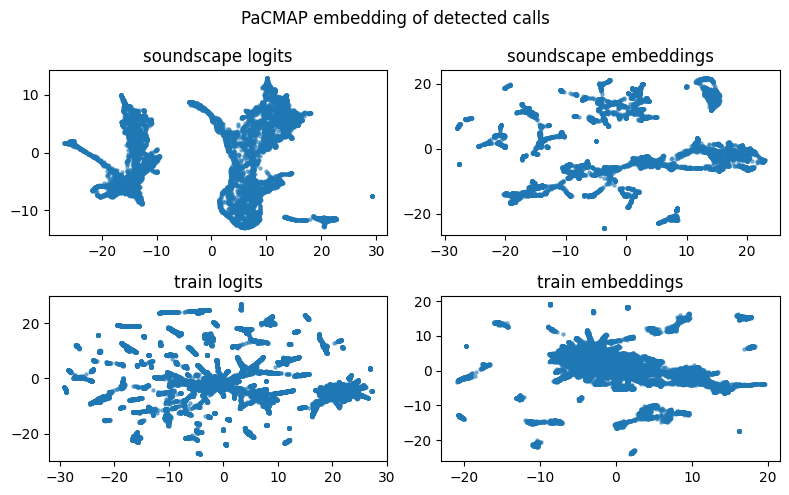

In [230]:
# create 4 subplots with the above reuslts
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

for i, (k, v) in enumerate(results.items()):
    ax = axs[i // 2, i % 2]
    ax.scatter(v[:, 0], v[:, 1], s=5, alpha=0.5)
    ax.set_title(k)

plt.suptitle("PaCMAP embedding of detected calls")
plt.tight_layout()
plt.show()